In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/Projekt2/dataset_Depth_map'

# Define the ratio for splitting the dataset
train_ratio = 0.8
test_ratio = 0.8

# Define the dataset transforms with augmentation
data_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the dataset
full_dataset = ImageFolder(dataset_path, data_transforms)

# Define the dataset sizes and split sizes
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Split the dataset into training and test sets
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create data loaders for training and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = full_dataset.classes





In [17]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)  # Output size based on your dataset's number of classes

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Apply adaptive pooling to get a consistent size before the fully connected layers
        x = self.adaptive_pool(x)

        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))

        x = self.fc3(x)
        return x

# Create the model and define the loss function and optimizer
device = torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch [1/10], Training Loss: 1.3548
Epoch [1/10], Validation Loss: 0.6730
Epoch [2/10], Training Loss: 0.5452
Epoch [2/10], Validation Loss: 0.2709
Epoch [3/10], Training Loss: 0.2210
Epoch [3/10], Validation Loss: 0.1487
Epoch [4/10], Training Loss: 0.1434
Epoch [4/10], Validation Loss: 0.0900
Epoch [5/10], Training Loss: 0.0717
Epoch [5/10], Validation Loss: 0.0686
Epoch [6/10], Training Loss: 0.0534
Epoch [6/10], Validation Loss: 0.0558
Epoch [7/10], Training Loss: 0.0461
Epoch [7/10], Validation Loss: 0.0543
Epoch [8/10], Training Loss: 0.0458
Epoch [8/10], Validation Loss: 0.0726
Epoch [9/10], Training Loss: 0.0451
Epoch [9/10], Validation Loss: 0.0480
Epoch [10/10], Training Loss: 0.0251
Epoch [10/10], Validation Loss: 0.0403


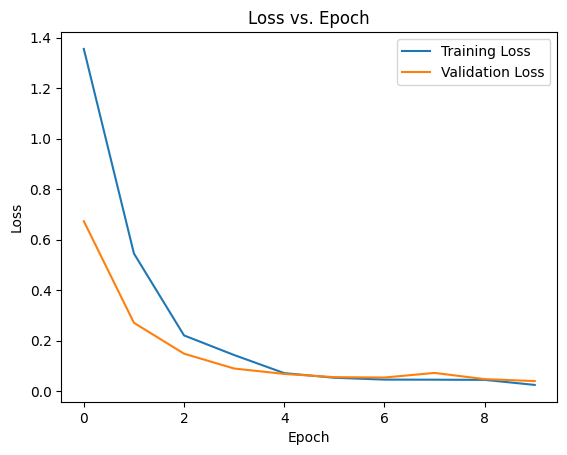

Training complete.
Training complete.


In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

num_epochs = 10
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):

    model.train()
    #epoch_train_loss = 0.0
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')


    model.eval()
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(test_loader)
    val_loss_values.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

plt.plot(train_loss_values, label=f"Training Loss")
plt.plot(val_loss_values, label=f"Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()
print("Training complete.")

print("Training complete.")


In [19]:
#MODEL1
# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.99%


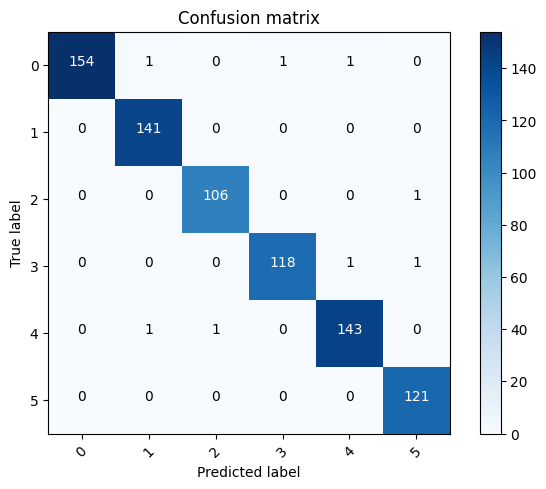

In [20]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import torch

num_classes = 6
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(int(cm[i, j]), 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)
        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

plot_confusion_matrix(confusion_matrix, list(range(num_classes)))